## Load data (The lego data)

# Full reconstruction workflow pipeline
This is an example of a full reconstruction workflow

In [1]:
#from ess.imaging.data import get_ymir_images_path
from ess.imaging.io import FilePath
from ess.imaging.normalize import NormalizedSampleImages, DarkCurrentImage, OpenBeamImage, SampleImageStacks
from ess.imaging.workflow import (
    YmirImageNormalizationWorkflow,
    ImageDetectorName,
    RotationMotionSensorName,
)
import numpy as np
import matplotlib.pyplot as plt
import pymuhrec.utils.readers as io
import pymuhrec.utils.imageutils as amg
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # Required to load data from ess/data/raw folders

# import nitools.imgalg.muhrectomo as mt
import pymuhrec as pm
#%config InlineBackend.figure_format = 'retina'

wf = YmirImageNormalizationWorkflow()
#wf[FilePath] = ("C:/Users/christianvedel/Imaging/597001_00011360.hdf")
wf[FilePath] = ("/ess/data/ymir/2024/597001/raw/597001_00011360.hdf")
wf[ImageDetectorName] = 'orca'
wf[RotationMotionSensorName] = 'motion_cabinet_2'


In [43]:
#wf.visualize(NormalizedSampleImages) # Visualize the full reduction workflow, squares are results which can be requested

## Inspect and Normalize 

In [4]:
wf

In [9]:
#target_types = (SampleImageStacks, DarkCurrentImage, OpenBeamImage)
target_types = (SampleImageStacks, DarkCurrentImage, OpenBeamImage, NormalizedSampleImages)

results = wf.compute(target_types)
raw_images = results[SampleImageStacks]
dc = results[DarkCurrentImage]
ob = results[OpenBeamImage]
normalized = results[NormalizedSampleImages]
normalized
#raw_images

c:\Users\christianvedel\AppData\Local\miniconda3\envs\new_pymuhrec\Lib\site-packages\ess\imaging\io.py:91: UserWarning: The unit of the histogram detector data is [None]. It is expected to be [counts]. The loader manually assigned the unit to be [counts].
  warnings.warn(


<scipp.DataArray>
Dimensions: Sizes[time:361, dim_1:2048, dim_2:2048, ]
Coordinates:
* dim_1                       int64  [dimensionless]  (dim_1)  [0, 1, ..., 2046, 2047]
* dim_2                       int64  [dimensionless]  (dim_2)  [0, 1, ..., 2046, 2047]
* rotation_angle            float64            [deg]  (time)  [-0.00373161, 1.00731, ..., 360.001, 361.004]
* time                    datetime64             [ns]  (time)  [2024-08-14T14:16:53.053141316, 2024-08-14T14:16:57.997255602, ..., 2024-08-14T14:46:10.004172279, 2024-08-14T14:46:14.913190949]
Data:
                            float64  [dimensionless]  (time, dim_1, dim_2)  [0.831584, 0.843397, ..., 0.753447, 0.644576]

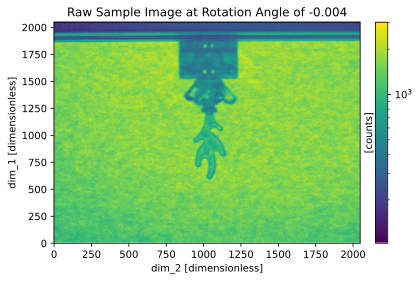

In [10]:
raw_images['time', 0].plot(
    title=f'Raw Sample Image at Rotation Angle of {raw_images.coords["rotation_angle"].values[0]:.3f}',
    norm='log'
)

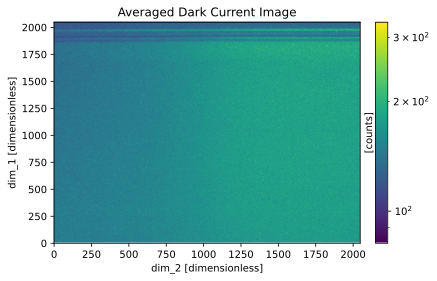

In [11]:
dc.plot(title='Averaged Dark Current Image', norm='log')

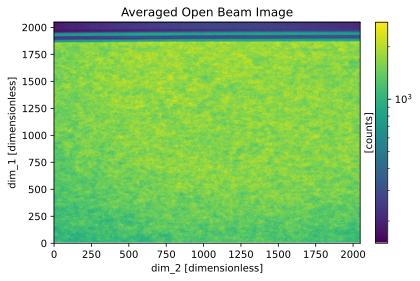

In [12]:
ob.plot(title='Averaged Open Beam Image', norm='log')

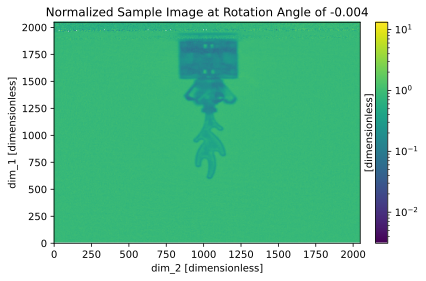

In [13]:
normalized['time', 0].plot(
    title=f'Normalized Sample Image at Rotation Angle of {normalized.coords["rotation_angle"].values[0]:.3f}',
    norm='log'
)

You can use a slicer to browse images along the rotation angle.

In [14]:
%matplotlib widget
from plopp import slicer
slicer(normalized, norm='log', autoscale=False)

InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', la…

In [ ]:
slicer(normalized, coords=['rotation_angle'], norm='log', autoscale=False)

If you want to bin the images by linear steps of angles,
you can use ``sc.groupby`` like below.

In [15]:
%matplotlib widget
import scipp as sc
from plopp import slicer

slicer(normalized.groupby(
    'rotation_angle',
    bins=sc.linspace(dim='time', start=-0.5, stop=4.5, num=5, unit='deg'),
).mean('time'), norm='log')

InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', la…

In [18]:
normalized.shape

(361, 2048, 2048)

In [16]:
%matplotlib widget
slicer(normalized["dim_2", 800:1250]["dim_1", 500:1900], norm='log')

InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', la…

In [19]:
cproj = normalized["dim_2", 800:1250]["dim_1", 500:1900].values
cproj.shape

(361, 1400, 450)

## Spot Cleaning

In [20]:
spot_cleaned_data = cproj.copy()

In [21]:
spotclean = pm.MorphSpotClean()
spotclean.setCleanMethod(detectionMethod=pm.MorphDetectAllSpots, cleanMethod=pm.MorphCleanReplace)
spotclean.process(spot_cleaned_data, th=[0.99, 0.99], sigma=[0.01, 0.01])

Process 2D: py::array_t<double> &x, std::vector<float> &th, std::vector<float> & sigma


### Visualization

Text(0.5, 1.0, 'm=-0.00596, s=0.04773')

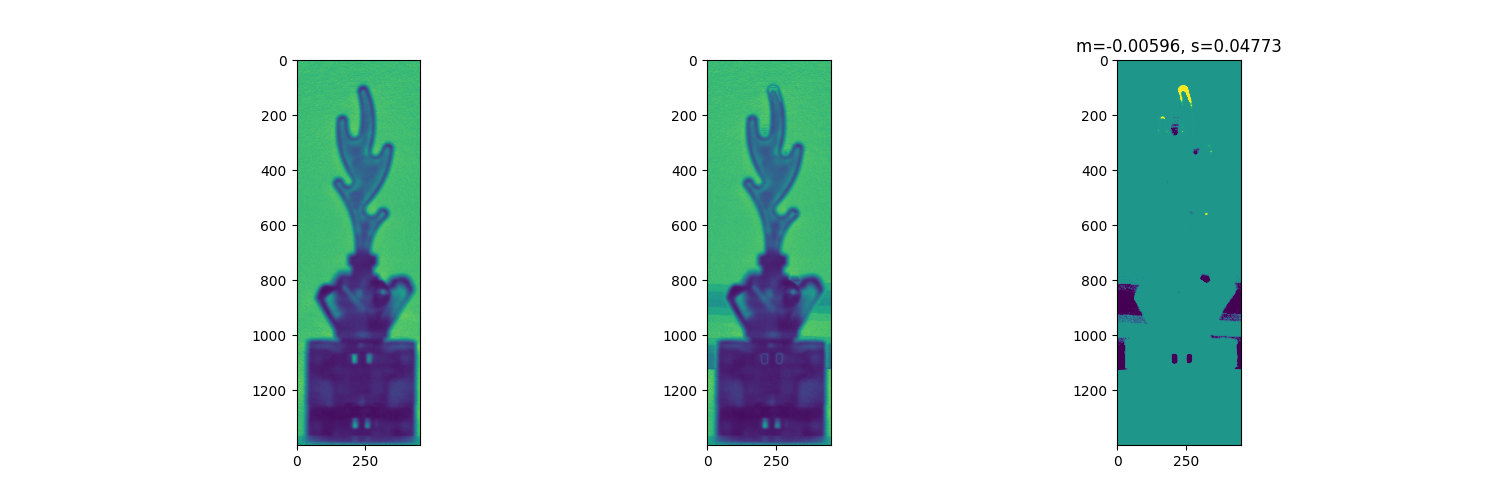

In [22]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
idx = 0
ax[0].imshow(cproj[idx])
ax[1].imshow(spot_cleaned_data[idx])
diff= spot_cleaned_data[idx]-cproj[idx]
m = diff.mean()
s = diff.std()
ax[2].imshow(spot_cleaned_data[idx]-cproj[idx],vmin=m-2*s,vmax=m+2*s);
ax[2].set_title("m={0:0.5f}, s={1:0.5f}".format(m,s))

## Ring Cleaning

In [23]:
ring_cleaned_data = spot_cleaned_data.copy()
ring_cleaned_data.shape

(361, 1400, 450)

In [24]:
ringclean = pm.StripeFilter([ring_cleaned_data.shape[2], ring_cleaned_data.shape[0]], "daub7", 4, 0.05)
ringclean.process(ring_cleaned_data, pm.eStripeFilterOperation.VerticalComponentFFT)

### Visualization

Text(0.5, 1.0, 'm=0.00000, s=0.00000')

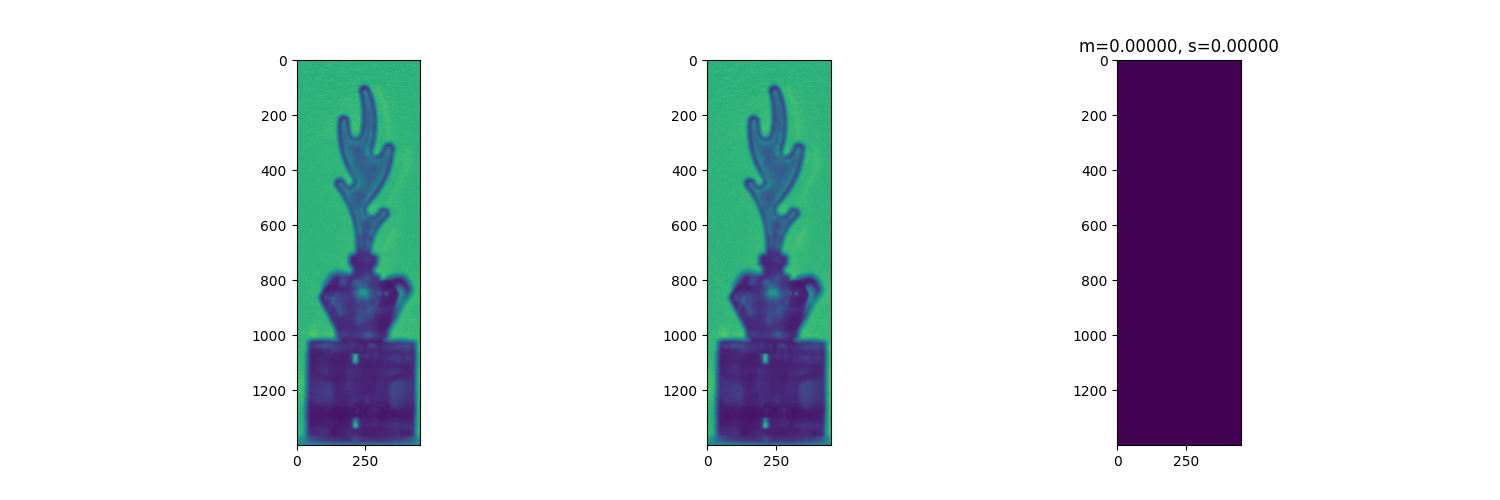

In [25]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
idx = 10
ax[0].imshow(spot_cleaned_data[idx])
ax[1].imshow(ring_cleaned_data[idx])
diff= ring_cleaned_data[idx]-spot_cleaned_data[idx]
m = diff.mean()
s = diff.std()
ax[2].imshow(ring_cleaned_data[idx]-spot_cleaned_data[idx],vmin=m-2*s,vmax=m+2*s);
ax[2].set_title("m={0:0.5f}, s={1:0.5f}".format(m,s))

## Center of rotation

In [26]:
Nproj = cproj.shape[0]

In [27]:
center = pm.TomoCenter()

In [28]:
center_estimate = center.estimate(ring_cleaned_data[0], ring_cleaned_data[ring_cleaned_data.shape[0]//2], pm.centerLeastSquare, False)

In [29]:
centers = center.centers()

In [30]:
center_estimate

(232.1095238095238, 0.0, 0.0)

### Visualization

In [31]:
def scale_to_0_1(img):
    return (img - img.min())/(img.max()-img.min())

In [32]:
angle_0 = scale_to_0_1(ring_cleaned_data[0])
angle_180 = scale_to_0_1(ring_cleaned_data[int(Nproj/2)])
mean = (angle_0 + angle_180)/2
rgb = np.stack((mean, angle_0, angle_180), axis=2)

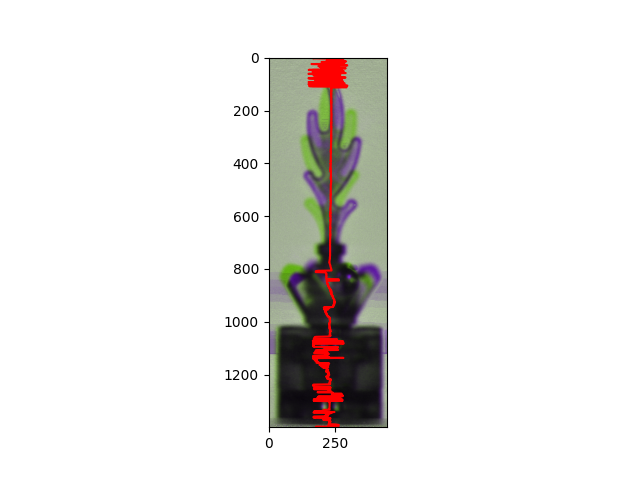

In [33]:
plt.figure()
plt.imshow(rgb)
plt.plot(centers, np.arange(len(centers)), 'r')

## Reconstruction

In [34]:
reconstructor = pm.Reconstructor(pm.bpMultiProjParallel)

In [35]:
angles = normalized.coords["rotation_angle"].values

In [36]:
args = {"angles": angles,
        "weights": np.ones(Nproj)}

In [37]:
reconstructor.configure({   "center" : center_estimate[0], 
                            "resolution" : 0.135
                        })

In [38]:
reconstructor.process(cproj, args)

450 1400 361


In [39]:
vol = reconstructor.volume()

In [40]:
np.shape(vol)

(1400, 450, 450)

In [41]:
#io.save_TIFF('C:/Users/christianvedel/Imaging/lego_reconstruction.tif', vol)

  0%|          | 0/1400 [00:00<?, ?it/s]

In [42]:
import tifffile as tiff
tiff.imwrite('C:/Users/christianvedel/Imaging/lego_reconstruction.tiff', vol)